# Leveraging Video-On-Demand streaming data for early forecast of a movie's success using Gradient Boosting Machines and advanced feature engineering techniques.
## Introduction
The goal of this project is to create a decision support system to aid movie investments at the early stage of a movie's production. The system predicts the success of a movie based on a streaming rank scoring measure by leveraging historical data from various sources. Using social network analysis and advanced natural language processing (NLP) techniques, the system automatically extracts several groups of features, including the “who” (cast and crew), the “what” (the plot)), as well as “hybrid” features that match “who” with “what”. In order to support investment decisions on a movie, the model has to be provided information that is available at the very early stage of the movie’s production. Consequently, our prediction of movie success can only leverage data that is available when a movie is still being planned. Predictions that are made right before or after the official release may have more data to use and get more accurate results, but they are too late for investors to make any meaningful decision.

# Setup

## Python libraries

In [63]:
import pandas as pd
from random import choice
import networkx as nx # Graph analyses
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import lightgbm as lgb # Prediction model
from utils import *
import matplotlib.pyplot as plt
import warnings

# Turn off the warnings
warnings.filterwarnings('ignore')

# Set the plt style to "ggplot"
plt.style.use('ggplot')

data_path = './data/'
countries = ['Mexico', 'Brazil', 'United States'] # Can be expanded to other countries

# Data Loading

### Training Set

In [2]:
main_df = pd.read_pickle(data_path + 'netflixmoviemain_df.pkl')
main_df

,country,jw_entity_id,rank,is_nflx_original,score,date,age_certification,object_type,original_release_year,original_title,...,genre_3,genre_4,genre_5,genre_6,genre_7,genre_8,genre_9,genre_10,genre_11,genre_12
0,Argentina,tm1000599,NaN,None,1.0,2021-11-07,None,movie,2021.0,A Última Floresta,...,None,None,None,None,None,None,None,None,None,None
1,Argentina,tm1000619,NaN,None,1.0,2022-05-07,None,movie,2022.0,రాధే శ్యామ్,...,None,None,None,None,None,None,None,None,None,None
2,Argentina,tm1001097,NaN,None,1.0,2022-06-29,R,movie,2022.0,Beauty,...,romance,None,None,None,None,None,None,None,None,None
3,Argentina,tm1001912,NaN,None,1.0,2022-03-02,None,movie,2021.0,Trust,...,romance,None,None,None,None,None,None,None,None,None
4,Argentina,tm1003034,NaN,None,1.0,2021-08-23,None,movie,2021.0,The Witcher: Nightmare of the Wolf,...,scifi,animation,action,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25831,Venezuela,tm996762,NaN,None,1.0,2022-07-07,None,movie,2022.0,మేజర్,...,None,None,None,None,None,None,None,None,None,None
25832,Venezuela,tm998033,NaN,None,1.0,2021-11-18,None,movie,2021.0,டாக்டர்,...,comedy,crime,None,None,None,None,None,None,None,None
25833,Venezuela,tm998992,NaN,None,1.0,2022-09-07,PG,movie,2021.0,竜とそばかすの姫,...,fantasy,music,scifi,None,None,None,None,None,None,None
25834,Venezuela,tm999817,NaN,None,1.0,2021-12-01,None,movie,2021.0,白蛇 II：青蛇劫起,...,action,None,None,None,None,None,None,None,None,None


In [3]:
titles = pd.read_pickle(data_path + 'titles.pkl')
talent = pd.read_pickle(data_path + 'talent.pkl')
talent = talent.merge(titles[['jw_entity_id', 'original_release_year', 'genre_1']], on='jw_entity_id', how='left')

# Create a feature called 'tenure' to measure the number of years between the earliest movie and the latest movie of each talent
talent['tenure'] = talent.groupby('person_id')['original_release_year'].transform(lambda x: x.max() - x.min())
talent

,role,character_name,person_id,name,title,jw_entity_id,original_release_year,genre_1,tenure
0,ACTOR,Janaki,68294,Meena,Avvai Shanmugi,tm110160,1996.0,drama,35.0
1,ACTOR,Joseph,145348,Nagesh,Avvai Shanmugi,tm110160,1996.0,drama,46.0
2,ACTOR,Bhai,45436,Nassar,Avvai Shanmugi,tm110160,1996.0,drama,35.0
3,ACTOR,Rathna,432833,Heera Rajgopal,Avvai Shanmugi,tm110160,1996.0,drama,6.0
4,ACTOR,Kousi,471253,Rani,Avvai Shanmugi,tm110160,1996.0,drama,6.0
...,...,...,...,...,...,...,...,...,...
959963,EDITOR,None,15210,Larry Bock,Remember the Daze,tm73324,2008.0,comedy,30.0
959964,EXECUTIVE_PRODUCER,None,618188,Kevin Loughery,Remember the Daze,tm73324,2008.0,comedy,1.0
959965,ORIGINAL_MUSIC_COMPOSER,None,33249,Dustin O'Halloran,Remember the Daze,tm73324,2008.0,comedy,14.0
959966,PRODUCER,None,17275,Matthew Rhodes,Remember the Daze,tm73324,2008.0,comedy,16.0


# Network Analysis

For demostration purposes let's start by focusing on Mexico

In [4]:
local_df, local_talent = get_country_dfs('Mexico', main_df, talent)
local_talent

,role,character_name,person_id,name,title,jw_entity_id,original_release_year,genre_1,tenure,score,talent_total_score,talent_average_score,talent_max_score,talent_min_score,talent_median_score,talent_std_score,talent_count,talent_total_role_score,talent_average_role_score
0,ACTOR,Charlie St. Cloud,12678,Zac Efron,Charlie St. Cloud,tm96023,2010.0,drama,17.0,1.0,2.0,1.0,1.0,1.0,1.0,0.0,2,2.0,1.0
1,ACTOR,Tess Carroll,23864,Amanda Crew,Charlie St. Cloud,tm96023,2010.0,drama,14.0,1.0,2.0,1.0,1.0,1.0,1.0,0.0,2,2.0,1.0
2,ACTOR,Tink Weatherbee,10698,Donal Logue,Charlie St. Cloud,tm96023,2010.0,drama,29.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,1,1.0,1.0
3,ACTOR,Florio Ferrente,5313,Ray Liotta,Charlie St. Cloud,tm96023,2010.0,drama,36.0,1.0,2.0,1.0,1.0,1.0,1.0,0.0,2,2.0,1.0
4,ACTOR,Connors,92289,Matt Ward,Charlie St. Cloud,tm96023,2010.0,drama,6.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,1,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35526,EXECUTIVE_PRODUCER,None,80065,Ashwin Rajan,Split,tm236706,2016.0,thriller,11.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,1,1.0,1.0
35527,ORIGINAL_MUSIC_COMPOSER,None,76651,West Dylan Thordson,Split,tm236706,2016.0,thriller,10.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,1,1.0,1.0
35528,PRODUCER,None,2243,Jason Blum,Split,tm236706,2016.0,thriller,22.0,1.0,11.0,1.0,1.0,1.0,1.0,0.0,11,11.0,1.0
35529,PRODUCTION_DESIGN,None,120673,Mara LePere-Schloop,Split,tm236706,2016.0,thriller,6.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,1,1.0,1.0


In [5]:
colab_matrix = get_colab_matrix(local_df, local_talent)
G, talent_centrality_measures = graph(colab_matrix)
talent_centrality_measures

,person_id,deg_cent,ein_cent,prank_cent
0,16,0.000698,1.568679e-12,0.000031
1,18,0.000698,1.568679e-12,0.000031
2,22939,0.000698,1.568679e-12,0.000031
3,138747,0.002277,8.495536e-11,0.000062
4,222873,0.000698,1.568679e-12,0.000031
...,...,...,...,...
27230,840825,0.000073,7.241075e-68,0.000037
27231,2360211,0.000073,7.241075e-68,0.000037
27232,2352928,0.000624,3.381036e-07,0.000033
27233,2363864,0.000991,1.374234e-07,0.000035


In [6]:
local_talent.drop(columns=['character_name', 'original_release_year', 'genre_1', 'score'], inplace=True)
local_talent.drop_duplicates(inplace=True)

# Group by 'person_id' and 'role' and take the first value of the rest of the columns
local_talent = local_talent.groupby(['person_id', 'role']).first().reset_index()

local_talent = local_talent.merge(talent_centrality_measures, on='person_id', how='left')

local_talent = local_talent.fillna(0)

# Group by 'jw_entity_id' and 'role' and take the mean of the rest of the columns
local_talent_title_agg = local_talent.drop(columns=['person_id', 'name', 'title']).groupby(['jw_entity_id', 'role']).mean().reset_index()

# Pivot the table to have 'jw_entity_id' as index, 'role' as columns and the rest of the columns as values
local_talent_title_agg = local_talent_title_agg.pivot(index='jw_entity_id', columns='role').reset_index()
local_talent_title_agg.columns = ['_'.join(col) for col in local_talent_title_agg.columns.values]
local_talent_title_agg.rename(columns={'jw_entity_id_': 'jw_entity_id'}, inplace=True)
local_talent_title_agg

,jw_entity_id,tenure_ACTOR,tenure_ASSISTANT_DIRECTOR,tenure_AUTHOR,tenure_CO_EXECUTIVE_PRODUCER,tenure_CO_PRODUCER,tenure_CO_WRITER,tenure_DIRECTOR,tenure_EDITOR,tenure_EXECUTIVE_PRODUCER,...,prank_cent_EDITOR,prank_cent_EXECUTIVE_PRODUCER,prank_cent_MUSIC,prank_cent_ORIGINAL_MUSIC_COMPOSER,prank_cent_PRODUCER,prank_cent_PRODUCTION_DESIGN,prank_cent_SCREENPLAY,prank_cent_SONGS,prank_cent_VISUAL_EFFECTS,prank_cent_WRITER
0,tm1000037,2.833333,NaN,NaN,NaN,NaN,NaN,6.0,6.0,NaN,...,0.000053,NaN,0.000029,NaN,0.000029,0.000053,NaN,NaN,NaN,0.000029
1,tm1000599,0.000000,NaN,NaN,NaN,NaN,NaN,20.0,4.0,NaN,...,0.000036,NaN,NaN,0.000036,0.000037,NaN,NaN,NaN,NaN,0.000039
2,tm1000619,18.166667,NaN,NaN,NaN,NaN,NaN,7.0,45.0,NaN,...,0.000032,NaN,NaN,0.000032,0.000032,0.000032,NaN,NaN,NaN,0.000033
3,tm1001097,11.000000,NaN,NaN,NaN,NaN,NaN,9.0,0.0,NaN,...,0.000026,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000050
4,tm1002815,5.076923,NaN,NaN,NaN,0.0,NaN,7.0,8.0,0.00,...,0.000045,0.000024,NaN,NaN,0.000074,0.000024,0.000045,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
962,tm996762,14.285714,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.00,...,0.000029,0.000029,NaN,0.000029,0.000029,0.000059,0.000031,NaN,NaN,NaN
963,tm998188,9.650000,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,...,NaN,NaN,NaN,NaN,0.000033,NaN,NaN,NaN,NaN,0.000046
964,tm998992,6.500000,NaN,NaN,NaN,NaN,NaN,15.0,28.0,2.25,...,0.000033,0.000041,NaN,0.000033,0.000033,0.000033,0.000034,0.000033,NaN,NaN
965,tm999817,0.812500,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,...,NaN,NaN,NaN,NaN,0.000037,NaN,NaN,NaN,NaN,0.000037


In [7]:
# Merge the 'local_df' with the 'local_talent_title_agg' table on 'jw_entity_id'
local_df = local_df.merge(local_talent_title_agg, on='jw_entity_id', how='left')
local_df

,country,jw_entity_id,rank,is_nflx_original,score,date,age_certification,object_type,original_release_year,original_title,...,prank_cent_EDITOR,prank_cent_EXECUTIVE_PRODUCER,prank_cent_MUSIC,prank_cent_ORIGINAL_MUSIC_COMPOSER,prank_cent_PRODUCER,prank_cent_PRODUCTION_DESIGN,prank_cent_SCREENPLAY,prank_cent_SONGS,prank_cent_VISUAL_EFFECTS,prank_cent_WRITER
0,Mexico,tm1000037,NaN,None,1.0,2021-09-23,R,movie,2021.0,Je suis Karl,...,0.000053,NaN,0.000029,NaN,0.000029,0.000053,NaN,NaN,NaN,0.000029
1,Mexico,tm1000599,NaN,None,1.0,2021-11-07,None,movie,2021.0,A Última Floresta,...,0.000036,NaN,NaN,0.000036,0.000037,NaN,NaN,NaN,NaN,0.000039
2,Mexico,tm1000619,NaN,None,1.0,2022-05-06,None,movie,2022.0,రాధే శ్యామ్,...,0.000032,NaN,NaN,0.000032,0.000032,0.000032,NaN,NaN,NaN,0.000033
3,Mexico,tm1001097,NaN,None,1.0,2022-06-29,R,movie,2022.0,Beauty,...,0.000026,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000050
4,Mexico,tm1002815,NaN,None,1.0,2021-09-15,None,movie,2021.0,Nightbooks,...,0.000045,0.000024,NaN,NaN,0.000074,0.000024,0.000045,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
976,Mexico,tm996762,NaN,None,1.0,2022-07-07,None,movie,2022.0,మేజర్,...,0.000029,0.000029,NaN,0.000029,0.000029,0.000059,0.000031,NaN,NaN,NaN
977,Mexico,tm998188,NaN,None,1.0,2021-12-01,None,movie,2021.0,Donde caben dos,...,NaN,NaN,NaN,NaN,0.000033,NaN,NaN,NaN,NaN,0.000046
978,Mexico,tm998992,NaN,None,1.0,2022-09-07,PG,movie,2021.0,竜とそばかすの姫,...,0.000033,0.000041,NaN,0.000033,0.000033,0.000033,0.000034,0.000033,NaN,NaN
979,Mexico,tm999817,NaN,None,1.0,2021-12-01,None,movie,2021.0,白蛇 II：青蛇劫起,...,NaN,NaN,NaN,NaN,0.000037,NaN,NaN,NaN,NaN,0.000037


# Plot scoring

In [8]:
# create a pandas series called 'plots' with the index as the movie's 'jw_entity_id' and the value as the movie's 'short_description'
plots = pd.Series(main_df['short_description'].values, index=main_df['jw_entity_id'])

# drop duplicate index vales from the plots series
plots = plots[~plots.index.duplicated(keep='first')]

# Drop null values from the plots series
plots.dropna(inplace=True)

scored_keywords = score_keywords(plots, main_df)
# Create a dataframe called 'scored_plots' with the 'node_weight_scored_by_keyword_and_country' column summed by 'jw_entity_id' and 'country'
scored_plots = scored_keywords.groupby(['jw_entity_id', 'country'])['node_weight_scored_by_keyword_and_country'].sum().reset_index()
scored_plots

0it [00:00, ?it/s]

Extracting keywords from the plot of each of 4124 movies...


4124it [00:51, 79.60it/s]


Total number of keywords extracted: 41148


,jw_entity_id,country,node_weight_scored_by_keyword_and_country
0,tm10,Hungary,22.590855
1,tm10,India,167.322700
2,tm10,South Africa,126.902840
3,tm1000037,France,70.888013
4,tm1000037,Greece,90.606945
...,...,...,...
25786,tm999927,South Africa,17.881518
25787,tm999927,Thailand,109.000463
25788,tm999927,United Kingdom,25.946371
25789,tm999927,Venezuela,43.813079


In [9]:
# Merge the 'local_df' with the 'scored_plots' table on 'jw_entity_id' and 'country'
local_df = local_df.merge(scored_plots, on=['jw_entity_id', 'country'], how='left')
local_df.rename(columns={'node_weight_scored_by_keyword_and_country': 'plot_score'}, inplace=True)
local_df

,country,jw_entity_id,rank,is_nflx_original,score,date,age_certification,object_type,original_release_year,original_title,...,prank_cent_EXECUTIVE_PRODUCER,prank_cent_MUSIC,prank_cent_ORIGINAL_MUSIC_COMPOSER,prank_cent_PRODUCER,prank_cent_PRODUCTION_DESIGN,prank_cent_SCREENPLAY,prank_cent_SONGS,prank_cent_VISUAL_EFFECTS,prank_cent_WRITER,plot_score
0,Mexico,tm1000037,NaN,None,1.0,2021-09-23,R,movie,2021.0,Je suis Karl,...,NaN,0.000029,NaN,0.000029,0.000053,NaN,NaN,NaN,0.000029,87.920444
1,Mexico,tm1000599,NaN,None,1.0,2021-11-07,None,movie,2021.0,A Última Floresta,...,NaN,NaN,0.000036,0.000037,NaN,NaN,NaN,NaN,0.000039,1.724854
2,Mexico,tm1000619,NaN,None,1.0,2022-05-06,None,movie,2022.0,రాధే శ్యామ్,...,NaN,NaN,0.000032,0.000032,0.000032,NaN,NaN,NaN,0.000033,152.159986
3,Mexico,tm1001097,NaN,None,1.0,2022-06-29,R,movie,2022.0,Beauty,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000050,132.204779
4,Mexico,tm1002815,NaN,None,1.0,2021-09-15,None,movie,2021.0,Nightbooks,...,0.000024,NaN,NaN,0.000074,0.000024,0.000045,NaN,NaN,NaN,70.232126
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
976,Mexico,tm996762,NaN,None,1.0,2022-07-07,None,movie,2022.0,మేజర్,...,0.000029,NaN,0.000029,0.000029,0.000059,0.000031,NaN,NaN,NaN,59.574578
977,Mexico,tm998188,NaN,None,1.0,2021-12-01,None,movie,2021.0,Donde caben dos,...,NaN,NaN,NaN,0.000033,NaN,NaN,NaN,NaN,0.000046,112.367622
978,Mexico,tm998992,NaN,None,1.0,2022-09-07,PG,movie,2021.0,竜とそばかすの姫,...,0.000041,NaN,0.000033,0.000033,0.000033,0.000034,0.000033,NaN,NaN,430.400154
979,Mexico,tm999817,NaN,None,1.0,2021-12-01,None,movie,2021.0,白蛇 II：青蛇劫起,...,NaN,NaN,NaN,0.000037,NaN,NaN,NaN,NaN,0.000037,78.210410


### Prediction Set

In [45]:
pred_set = pd.read_csv(data_path + 'project_form - movie.csv')

# make all column names lowercase
pred_set.columns = map(str.lower, pred_set.columns)

mask = ~pred_set['title'].isna()
pred_set['title'] = pred_set['title'].ffill()

# Create a 'pred_set_talent' dataframe that contains only the 'title', 'name', and 'role' columns
pred_set_talent = pred_set[['title', 'name', 'role']]

pred_set_talent.dropna(inplace=True)
pred_metadata = pred_set_talent.groupby(['title', 'role'])[['name']].agg(lambda x: ', '.join(x)).unstack().reset_index()
pred_metadata.dropna(axis=1, how='all', inplace=True)
pred_metadata.columns = [col[1] for col in pred_metadata.columns.values]
pred_metadata.rename(columns={'': 'title'}, inplace=True)

/var/folders/8y/0ldkfh015gjc7lvpvxd7pr380000gn/T/ipykernel_60333/1509321897.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_set_talent.dropna(inplace=True)


In [46]:
local_talent_crew_agg = local_talent.drop(columns=['person_id', 'title', 'jw_entity_id']).drop_duplicates()
local_talent_crew_agg = local_talent_crew_agg.groupby(['name', 'role']).mean().reset_index()
local_talent_crew_agg

,name,role,tenure,talent_total_score,talent_average_score,talent_max_score,talent_min_score,talent_median_score,talent_std_score,talent_count,talent_total_role_score,talent_average_role_score,deg_cent,ein_cent,prank_cent
0,50 Cent,ACTOR,17.0,2.0,1.0,1.0,1.0,1.0,0.0,2.0,2.0,1.0,0.003341,1.645165e-04,0.000049
1,A Martinez,ACTOR,50.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.000881,2.795196e-06,0.000025
2,A. C. Murali Mohan,ACTOR,7.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.001102,5.724415e-08,0.000033
3,A. Demetrius Brown,EXECUTIVE_PRODUCER,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.001248,8.558134e-05,0.000026
4,A. Jay Radcliff,ACTOR,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.000991,9.345656e-05,0.000019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28888,Игорь Павлов,ACTOR,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.001763,1.772953e-07,0.000035
28889,杨轶,ACTOR,8.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.000991,6.601263e-06,0.000033
28890,王俊凯,ACTOR,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.001395,6.468249e-04,0.000024
28891,陆树铭,ACTOR,0.0,2.0,1.0,1.0,1.0,1.0,0.0,2.0,2.0,1.0,0.000441,1.905546e-09,0.000030


In [47]:
# Merge the 'pred_set_talent' dataframe with the 'local_talent' dataframe on the 'name' column
pred_set_talent = pred_set_talent.merge(local_talent_crew_agg, on=['name', 'role'], how='left')
pred_set_talent

,title,name,role,tenure,talent_total_score,talent_average_score,talent_max_score,talent_min_score,talent_median_score,talent_std_score,talent_count,talent_total_role_score,talent_average_role_score,deg_cent,ein_cent,prank_cent
0,WAY DOWN,Liam Cunningham,ACTOR,26.0,13.0,4.333333,11.0,1.0,1.0,5.773503,3.0,13.0,4.333333,0.005618,0.000134,0.000082
1,WAY DOWN,Astrid Bergès-Frisbey,ACTOR,10.0,11.0,11.000000,11.0,11.0,11.0,0.000000,1.0,11.0,11.000000,0.002020,0.000003,0.000036
2,WAY DOWN,Freddie Highmore,ACTOR,20.0,24.0,6.000000,11.0,1.0,6.0,5.773503,4.0,13.0,4.333333,0.004773,0.000187,0.000073
3,WAY DOWN,Jaume Balagueró,DIRECTOR,16.0,11.0,11.000000,11.0,11.0,11.0,0.000000,1.0,11.0,11.000000,0.002020,0.000003,0.000036
4,WAY DOWN,Álvaro Augustín,PRODUCER,16.0,14.0,3.500000,11.0,1.0,1.0,5.000000,4.0,14.0,3.500000,0.004443,0.000004,0.000098
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5529,MUSK,ALEX GIBNEY,DIRECTOR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5530,MUSK,Black Bear,PRODUCER,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5531,MUSK,JIGSAW PRODUCTIONS,PRODUCER,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5532,MUSK,CLOSER MEDIA,PRODUCER,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [48]:
pred_set_talent = pred_set_talent.drop(columns=['name']).groupby(['title', 'role']).mean().reset_index()

# Pivot the table to have 'title' as index, 'role' as columns and the rest of the columns as values
pred_set_talent = pred_set_talent.pivot(index='title', columns='role').reset_index()
pred_set_talent.columns = ['_'.join(col) for col in pred_set_talent.columns.values]
pred_set_talent.rename(columns={'title_': 'title'}, inplace=True)
pred_set_talent

,title,tenure_ACTOR,tenure_CO_PRODUCER,tenure_DIRECTOR,tenure_EDITOR,tenure_EXECUTIVE_PRODUCER,tenure_PRODUCER,tenure_PRODUCTION_DESIGN,tenure_SCREENPLAY,tenure_WRITER,...,ein_cent_WRITER,prank_cent_ACTOR,prank_cent_CO_PRODUCER,prank_cent_DIRECTOR,prank_cent_EDITOR,prank_cent_EXECUTIVE_PRODUCER,prank_cent_PRODUCER,prank_cent_PRODUCTION_DESIGN,prank_cent_SCREENPLAY,prank_cent_WRITER
0,10 Lives,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100 MINUTES,NaN,NaN,NaN,NaN,NaN,8.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000062,NaN,NaN,NaN
2,2 WIN,18.0,NaN,NaN,NaN,NaN,44.0,NaN,NaN,NaN,...,NaN,0.000036,NaN,NaN,NaN,NaN,0.000028,NaN,NaN,NaN
3,2067,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.000037,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3 DAYS IN MALAY,31.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.000029,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
881,YOUTH,42.0,NaN,NaN,NaN,NaN,32.0,NaN,NaN,NaN,...,NaN,0.000053,NaN,NaN,NaN,NaN,0.000025,NaN,NaN,NaN
882,You Can't Run Forever,40.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.000133,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
883,ZERO CONTACT,24.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.000033,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
884,ZEROS AND ONES,37.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.000101,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [49]:
pred_set = pred_set[mask].drop(columns=['name', 'role'])

# Drop rows with missing values for 'plot'
pred_set = pred_set.dropna(subset=['plot'])

pred_set

,title,plot,age_certification,genre_1,genre_2,genre_3,comentarios_vivi,budget,ask,sales,market,status
0,WAY DOWN,The Bank of Spain is like no other. An absolut...,PG-13,action,thriller,NaN,NaN,NaN,NaN,TF1,NaN,NaN
7,THE GOOD BOSS,It’s a sharp and nuanced dark comedy about the...,PG-13,comedy,drama,NaN,"Es una comedia negra, por momentos bastante di...","3,000,000","250,000",MK2,NaN,NaN
9,LOIS WAIN,Louis Wain: Unconventional while iconic. Candi...,R,drama,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,RIO,"Set against the exotic backdrop of Brazil, thi...",R,thriller,action,NaN,NaN,NaN,NaN,STUDIOCANAL,EFM 2022,NaN
17,EMILY,Emily (Emma Mackey) wears a mask. The world te...,R,drama,NaN,NaN,Tipica historia tipo Pride and Prejudice. Se p...,Budget £8m,Asking para Latam: US$600k.,EMBANKMENT,Cannes 2022,Status Post-Production. Delivery Q1 2022
...,...,...,...,...,...,...,...,...,...,...,...,...
5540,CINNAMON,This darkly comedic heist thriller follows asp...,PG-13,thriller,comedy,NaN,NaN,NaN,Ask: 75K,VILLAGE ROADSHOW,CANNES 2023,NaN
5544,THE SALTED PATH,An honest and life-affirming true story of the...,R,drama,NaN,NaN,NaN,NaN,Ask: 450K,ROCKET SCIENCE,CANNES 2023,Pre prod. Shooting Date: 5th June 2023
5549,CONTROL,"Wallace Conway, a troubled doctor who increasi...",PG-13,thriller,drama,NaN,"Lei las primeras 40 paginas, es excelente, atr...",NaN,NaN,STUDIOCANAL,CANNES 2023,NaN
5553,CLIFFHANGER,Sylvester Stallone will reprise his character ...,PG-13,action,NaN,NaN,NaN,NaN,NaN,ROCKET SCIENCE,CANNES 2023,Shooting Date: September 2023


In [50]:
# Merge the 'pred_set' dataframe with the 'pred_set_talent' dataframe on the 'title' column
pred_set = pred_set.merge(pred_set_talent, on='title', how='left')
pred_set

,title,plot,age_certification,genre_1,genre_2,genre_3,comentarios_vivi,budget,ask,sales,...,ein_cent_WRITER,prank_cent_ACTOR,prank_cent_CO_PRODUCER,prank_cent_DIRECTOR,prank_cent_EDITOR,prank_cent_EXECUTIVE_PRODUCER,prank_cent_PRODUCER,prank_cent_PRODUCTION_DESIGN,prank_cent_SCREENPLAY,prank_cent_WRITER
0,WAY DOWN,The Bank of Spain is like no other. An absolut...,PG-13,action,thriller,NaN,NaN,NaN,NaN,TF1,...,NaN,0.000064,NaN,0.000036,NaN,NaN,0.000086,NaN,NaN,NaN
1,THE GOOD BOSS,It’s a sharp and nuanced dark comedy about the...,PG-13,comedy,drama,NaN,"Es una comedia negra, por momentos bastante di...","3,000,000","250,000",MK2,...,NaN,0.000095,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,LOIS WAIN,Louis Wain: Unconventional while iconic. Candi...,R,drama,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.000090,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,RIO,"Set against the exotic backdrop of Brazil, thi...",R,thriller,action,NaN,NaN,NaN,NaN,STUDIOCANAL,...,NaN,0.000083,NaN,NaN,NaN,NaN,0.000077,NaN,NaN,NaN
4,EMILY,Emily (Emma Mackey) wears a mask. The world te...,R,drama,NaN,NaN,Tipica historia tipo Pride and Prejudice. Se p...,Budget £8m,Asking para Latam: US$600k.,EMBANKMENT,...,NaN,0.000053,NaN,NaN,NaN,NaN,0.000026,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
900,CINNAMON,This darkly comedic heist thriller follows asp...,PG-13,thriller,comedy,NaN,NaN,NaN,Ask: 75K,VILLAGE ROADSHOW,...,NaN,0.000031,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
901,THE SALTED PATH,An honest and life-affirming true story of the...,R,drama,NaN,NaN,NaN,NaN,Ask: 450K,ROCKET SCIENCE,...,NaN,0.000032,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
902,CONTROL,"Wallace Conway, a troubled doctor who increasi...",PG-13,thriller,drama,NaN,"Lei las primeras 40 paginas, es excelente, atr...",NaN,NaN,STUDIOCANAL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
903,CLIFFHANGER,Sylvester Stallone will reprise his character ...,PG-13,action,NaN,NaN,NaN,NaN,NaN,ROCKET SCIENCE,...,NaN,0.000203,NaN,NaN,NaN,NaN,0.000177,NaN,NaN,NaN


In [51]:
# Create a pandas series called 'pred_set_plots' with the index as the movie's 'title' and the value as the movie's 'plot'
pred_set_plots = pd.Series(pred_set['plot'].values, index=pred_set['title'])
pred_set_keywords = extract_keywords(pred_set_plots)
pred_set_keywords.rename(columns={'jw_entity_id':'title'}, inplace=True)
pred_set_keywords

0it [00:00, ?it/s]

1it [00:00,  9.39it/s]

Extracting keywords from the plot of each of 905 movies...


905it [00:15, 56.89it/s]


Total number of keywords extracted: 15664


,keyword,node_weight,title,node_weight_normalized
0,bank,1.875803,WAY DOWN,0.065588
1,blueprints,0.150000,WAY DOWN,0.005245
2,maps,0.150000,WAY DOWN,0.005245
3,data,0.812003,WAY DOWN,0.028392
4,vault,1.895684,WAY DOWN,0.066283
...,...,...,...,...
15732,Guys,0.150000,MUSK,0.023810
15733,sister,0.955729,MUSK,0.151703
15734,company,1.144323,MUSK,0.181639
15735,MEDIA,1.144323,MUSK,0.181639


In [52]:
# Create a dataframe called 'pred_set_keywords_scored' which is the inner merge of 'pred_set_keywords' and 'scored_keywords' on 'keyword'
pred_set_keywords_scored = pred_set_keywords.drop('node_weight', axis=1).merge(scored_keywords[['keyword', 'country', 'node_weight_scored_by_keyword_and_country']], on=['keyword'], how='inner')
pred_set_keywords_scored['node_weight_scored_by_keyword_and_country'] = pred_set_keywords_scored['node_weight_scored_by_keyword_and_country'] * pred_set_keywords_scored['node_weight_normalized']
pred_set_keywords_scored.drop(columns=['node_weight_normalized'], inplace=True)
pred_set_keywords_scored.drop_duplicates(inplace=True)
pred_set_keywords_scored

,keyword,title,country,node_weight_scored_by_keyword_and_country
0,bank,WAY DOWN,Argentina,0.090901
13,bank,WAY DOWN,Brazil,0.152433
25,bank,WAY DOWN,Chile,0.076533
36,bank,WAY DOWN,Colombia,0.073204
47,bank,WAY DOWN,Czech Republic,0.034355
...,...,...,...,...
6076455,Blood,MUSK,Czech Republic,0.003968
6076456,Blood,MUSK,Hungary,0.003968
6076457,Blood,MUSK,Indonesia,0.015873
6076458,Blood,MUSK,Romania,0.194444


In [53]:
# Create a dataframe called 'pred_set_plots_scored' which is the sum of 'node_weight_scored_by_keyword_and_country' grouped by 'title' and 'country'
pred_set_plots_scored = pred_set_keywords_scored.groupby(['title', 'country'])['node_weight_scored_by_keyword_and_country'].sum().reset_index()
pred_set_plots_scored

,title,country,node_weight_scored_by_keyword_and_country
0,10 Lives,Argentina,4.481022
1,10 Lives,Austria,4.577243
2,10 Lives,Belgium,3.445158
3,10 Lives,Brazil,3.892160
4,10 Lives,Canada,3.926544
...,...,...,...
32369,ZOYA,Thailand,18.053885
32370,ZOYA,Turkey,0.496701
32371,ZOYA,United Kingdom,3.963960
32372,ZOYA,United States,5.337483


In [54]:
pred_set_plots_scored = pred_set_plots_scored[pred_set_plots_scored['country'] == 'Mexico']
pred_set_plots_scored.drop(columns=['country'], inplace=True)
pred_set_plots_scored.rename(columns={'node_weight_scored_by_keyword_and_country': 'plot_score'}, inplace=True)
pred_set_plots_scored

/Users/alejandroleda/opt/anaconda3/envs/filmPredictions/lib/python3.9/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
/Users/alejandroleda/opt/anaconda3/envs/filmPredictions/lib/python3.9/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,title,plot_score
20,10 Lives,4.625752
57,100 MINUTES,5.154279
94,2 WIN,1.154846
131,2067,5.793525
168,3 DAYS IN MALAY,2.709958
...,...,...
32210,YOUTH,11.655681
32247,You Can't Run Forever,10.671639
32283,ZERO CONTACT,7.676429
32320,ZEROS AND ONES,6.945345


In [55]:
# Merge the 'pred_set' dataframe with the 'pred_set_plots_scored' dataframe on the 'title' column
pred_set = pred_set.merge(pred_set_plots_scored, on='title', how='left')
pred_set

,title,plot,age_certification,genre_1,genre_2,genre_3,comentarios_vivi,budget,ask,sales,...,prank_cent_ACTOR,prank_cent_CO_PRODUCER,prank_cent_DIRECTOR,prank_cent_EDITOR,prank_cent_EXECUTIVE_PRODUCER,prank_cent_PRODUCER,prank_cent_PRODUCTION_DESIGN,prank_cent_SCREENPLAY,prank_cent_WRITER,plot_score
0,WAY DOWN,The Bank of Spain is like no other. An absolut...,PG-13,action,thriller,NaN,NaN,NaN,NaN,TF1,...,0.000064,NaN,0.000036,NaN,NaN,0.000086,NaN,NaN,NaN,3.892570
1,THE GOOD BOSS,It’s a sharp and nuanced dark comedy about the...,PG-13,comedy,drama,NaN,"Es una comedia negra, por momentos bastante di...","3,000,000","250,000",MK2,...,0.000095,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.252422
2,LOIS WAIN,Louis Wain: Unconventional while iconic. Candi...,R,drama,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000090,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.386607
3,RIO,"Set against the exotic backdrop of Brazil, thi...",R,thriller,action,NaN,NaN,NaN,NaN,STUDIOCANAL,...,0.000083,NaN,NaN,NaN,NaN,0.000077,NaN,NaN,NaN,4.470841
4,EMILY,Emily (Emma Mackey) wears a mask. The world te...,R,drama,NaN,NaN,Tipica historia tipo Pride and Prejudice. Se p...,Budget £8m,Asking para Latam: US$600k.,EMBANKMENT,...,0.000053,NaN,NaN,NaN,NaN,0.000026,NaN,NaN,NaN,7.938387
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
900,CINNAMON,This darkly comedic heist thriller follows asp...,PG-13,thriller,comedy,NaN,NaN,NaN,Ask: 75K,VILLAGE ROADSHOW,...,0.000031,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.962646
901,THE SALTED PATH,An honest and life-affirming true story of the...,R,drama,NaN,NaN,NaN,NaN,Ask: 450K,ROCKET SCIENCE,...,0.000032,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.703175
902,CONTROL,"Wallace Conway, a troubled doctor who increasi...",PG-13,thriller,drama,NaN,"Lei las primeras 40 paginas, es excelente, atr...",NaN,NaN,STUDIOCANAL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.177793
903,CLIFFHANGER,Sylvester Stallone will reprise his character ...,PG-13,action,NaN,NaN,NaN,NaN,NaN,ROCKET SCIENCE,...,0.000203,NaN,NaN,NaN,NaN,0.000177,NaN,NaN,NaN,0.047980


# Encode dataset and Hyper-parameter tunning

In [21]:
X_data, y_data, X_pred, col_names = encode(local_df, pred_set)
lgbm_results = get_lgbm_params(X_data, y_data)
best_params = lgbm_results['parameters'].iloc[lgbm_results['rmse'].idxmin()]
best_iter = lgbm_results['best_iteration'].iloc[lgbm_results['rmse'].idxmin()]
lgbm_results.sort_values("rmse", ascending=True, axis=0).head()

Random search start...

[LightGBM] [Warning] bagging_fraction is set=0.3, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3
[LightGBM] [Warning] bagging_fraction is set=0.3, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3
[LightGBM] [Warning] bagging_fraction is set=0.3, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3
[LightGBM] [Warning] bagging_fraction is set=0.3, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3
[LightGBM] [Warning] bagging_fraction is set=0.3, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3
[LightGBM] [Warning] bagging_fraction is set=0.3, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3
[LightGBM] [Warning] bagging_fraction is set=0.3, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3
[LightGBM] [Warning] bagging_fraction is set=0.3, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3
[LightGBM] [Warning] bagging_fraction is

,rmse,mae,map,parameters,best_iteration
111,2.043082,1.915331,1.775954,"{'num_leaves': 31, 'bagging_fraction': 0.5, 'c...",3
164,2.073080,1.562232,1.392499,"{'num_leaves': 61, 'bagging_fraction': 0.4, 'c...",21
274,2.261560,2.039405,1.888530,"{'num_leaves': 61, 'bagging_fraction': 0.3, 'c...",6
372,2.515890,2.344355,2.135284,"{'num_leaves': 20, 'bagging_fraction': 0.6, 'c...",5
33,2.533061,2.383373,2.254902,"{'num_leaves': 81, 'bagging_fraction': 0.4, 'c...",10


In [24]:
y_pred, gbm = predict(X_data, y_data, X_pred, best_params)

[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5


In [57]:
pred_set['score'] = y_pred
pred_set

,title,plot,age_certification,genre_1,genre_2,genre_3,comentarios_vivi,budget,ask,sales,...,prank_cent_CO_PRODUCER,prank_cent_DIRECTOR,prank_cent_EDITOR,prank_cent_EXECUTIVE_PRODUCER,prank_cent_PRODUCER,prank_cent_PRODUCTION_DESIGN,prank_cent_SCREENPLAY,prank_cent_WRITER,plot_score,score
0,WAY DOWN,The Bank of Spain is like no other. An absolut...,PG-13,action,thriller,NaN,NaN,NaN,NaN,TF1,...,NaN,0.000036,NaN,NaN,0.000086,NaN,NaN,NaN,3.892570,15.664425
1,THE GOOD BOSS,It’s a sharp and nuanced dark comedy about the...,PG-13,comedy,drama,NaN,"Es una comedia negra, por momentos bastante di...","3,000,000","250,000",MK2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.252422,0.648002
2,LOIS WAIN,Louis Wain: Unconventional while iconic. Candi...,R,drama,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.386607,0.648002
3,RIO,"Set against the exotic backdrop of Brazil, thi...",R,thriller,action,NaN,NaN,NaN,NaN,STUDIOCANAL,...,NaN,NaN,NaN,NaN,0.000077,NaN,NaN,NaN,4.470841,0.648002
4,EMILY,Emily (Emma Mackey) wears a mask. The world te...,R,drama,NaN,NaN,Tipica historia tipo Pride and Prejudice. Se p...,Budget £8m,Asking para Latam: US$600k.,EMBANKMENT,...,NaN,NaN,NaN,NaN,0.000026,NaN,NaN,NaN,7.938387,0.648002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
900,CINNAMON,This darkly comedic heist thriller follows asp...,PG-13,thriller,comedy,NaN,NaN,NaN,Ask: 75K,VILLAGE ROADSHOW,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.962646,0.648002
901,THE SALTED PATH,An honest and life-affirming true story of the...,R,drama,NaN,NaN,NaN,NaN,Ask: 450K,ROCKET SCIENCE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.703175,0.648002
902,CONTROL,"Wallace Conway, a troubled doctor who increasi...",PG-13,thriller,drama,NaN,"Lei las primeras 40 paginas, es excelente, atr...",NaN,NaN,STUDIOCANAL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.177793,0.648002
903,CLIFFHANGER,Sylvester Stallone will reprise his character ...,PG-13,action,NaN,NaN,NaN,NaN,NaN,ROCKET SCIENCE,...,NaN,NaN,NaN,NaN,0.000177,NaN,NaN,NaN,0.047980,-1.627425


# Results

In [61]:
cols2use = ['title', 'score', 'plot_score', 'genre_1', 'genre_2', 'plot']
output = pred_set[cols2use + [col for col in pred_set.columns if 'talent_total_role_score' in col]]
output = output.merge(pred_metadata, on='title')

# Re-arrange the columns of the 'output' dataframe such that the 'ACTOR' column is followed by the 'talent_total_score_ACTOR', the 'PRODUCER' column is followed by the 'talent_total_score_PRODUCER', and so on.
output = output[['title', 'score', 'plot_score', 'genre_1', 'genre_2', 'plot'] + [col for col in output.columns if 'DIRECTOR' in col] + [col for col in output.columns if 'ACTOR' in col] + [col for col in output.columns if 'PRODUCER' in col] + [col for col in output.columns if 'WRITER' in col]]
output.sort_values('score', ascending=False)

,title,score,plot_score,genre_1,genre_2,plot,talent_total_role_score_DIRECTOR,DIRECTOR,talent_total_role_score_ACTOR,ACTOR,talent_total_role_score_CO_PRODUCER,talent_total_role_score_EXECUTIVE_PRODUCER,talent_total_role_score_PRODUCER,CO_PRODUCER,EXECUTIVE_PRODUCER,PRODUCER,talent_total_role_score_WRITER,WRITER
87,HARRY HAFT,59.493792,16.625771,drama,NaN,The incredible true story of Harry Haft's figh...,12.0,Barry Levinson,42.000000,"Ben Foster, Vicky Krieps, Billy Magnussen, Dan...",NaN,NaN,6.5,NaN,NaN,"Matti Leshem, Aaron L. Gilbert, Barry Levinson...",NaN,NaN
219,RIDE THE EAGLE,44.417541,18.847682,comedy,NaN,Leif is left with a conditional inheritance wh...,NaN,Trent O’Donnell,37.666667,"Susan Sarandon, J.K. Simmons, Jake Johnson, D’...",NaN,NaN,NaN,NaN,NaN,"Trent O’Donnell, Jake Johnson, D’Arcy Carden",NaN,Trent O’Donnell
408,MASON COUNTY,42.962219,3.712542,action,thriller,Synopsis: Officer PAUL BLACKSMITH (Mel Gibson)...,NaN,NaN,37.000000,Mel Gibson,NaN,NaN,NaN,NaN,NaN,EFO,NaN,NaN
698,Girl From The North Country,42.962219,19.311537,NaN,NaN,"Set in Dylan's home-state of Minnesota, GIRL F...",NaN,Conor McPherson,37.500000,"Chlöe Bailey, Olivia Colman, Woody Harrelson",NaN,NaN,NaN,NaN,NaN,NaN,NaN,Conor McPherson
209,HOT SEAT,42.962219,3.034254,action,NaN,"Wallace Reed (Mel Gibson), veteran bomb squad ...",NaN,JAMES CULLEN BRESSACK,37.000000,"Mel Gibson, CHAD MICHAEL MURRAY",NaN,NaN,NaN,NaN,NaN,"RANDELL EMMETT, GEORGE FURLA",NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
641,HURRICANA,-27.560455,9.222877,drama,NaN,Synopsis: In an attempt to save Anna Nicole Sm...,NaN,Francesca Gregorini,8.500000,"Sylvia Hoeks, Holly Hunter",NaN,NaN,NaN,NaN,NaN,"Rory Koslow, Cassian Elwes, Well Told Entertai...",NaN,"Rachel Sarnoff, Matt Sarnoff"
547,Wizards!,-33.400288,2.447680,action,NaN,Synopsis: A laugh-out-loud buddy comedy set on...,NaN,David Michod,26.750000,"Pete Davidson, Franz Rogowski, Orlando Bloom, ...",NaN,NaN,NaN,NaN,NaN,Liz Watts,NaN,David Michod
156,TWICE CUT,-33.400288,1.808160,action,NaN,Convict Albert Crawley (Samuel L. Jackson) sen...,1.0,Catherine Hardwicke,27.750000,"Samuel L. Jackson, Naomi Watts, 50 Cent, Pete ...",NaN,NaN,NaN,NaN,NaN,"Rob Paris, Mike Witherill, Jonah Loop",NaN,NaN
227,NO PLACE LIKE KILL,-40.604204,3.942886,action,thriller,A vengeance driven mercenary and a police info...,NaN,Mat Newman,11.000000,Sam Riley,NaN,NaN,NaN,NaN,Charles Collier,"Sunrise Films' Rupert Preston, Moonage Picture...",NaN,"Mat Newman, Ben Newman"


# Feature importances

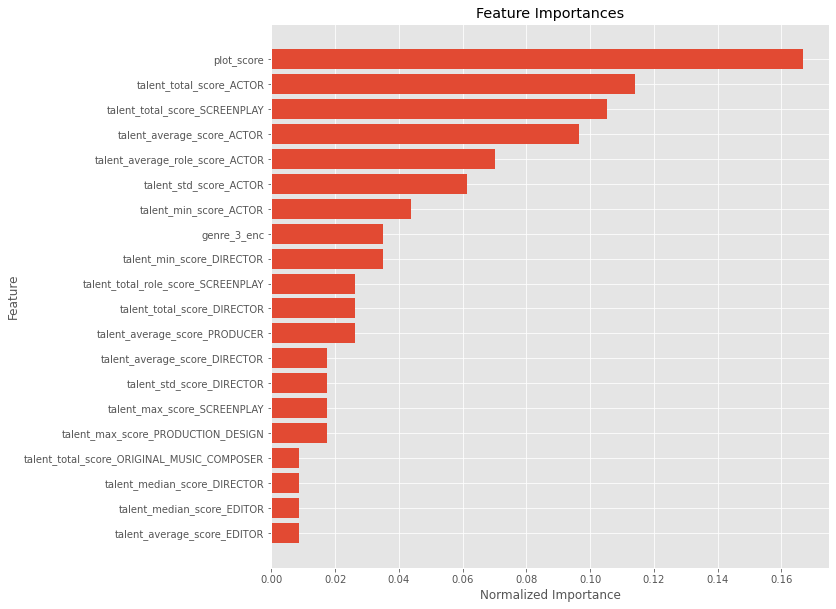

In [67]:
importances = gbm.feature_importances_
importances_normed = importances / importances.sum()
feat_importances = pd.DataFrame(list(zip(col_names, importances_normed)), columns=['feature', 'importance'])
feat_importances.sort_values('importance', ascending=False, inplace=True)

# Plot the first 20 feature importances using horizontal bars
plt.figure(figsize=(10, 10))
plt.barh(feat_importances['feature'][:20], feat_importances['importance'][:20])
plt.gca().invert_yaxis()
plt.title('Feature Importances')
plt.xlabel('Normalized Importance')
plt.ylabel('Feature')
plt.show()
